## Overview
This project has 2 main parts.
  1. Develop a **Pulse Rate Algorithm** on the given training data. Then **Test Your Algorithm** and see that it has met the success criteria.
  2.   Apply the Pulse Rate Algorithm on a **Clinical Application** and compute more clinically meaningful features and discover healthcare trends.
#### Introduction
A core feature that many users expect from their wearable devices is pulse rate estimation. Continuous pulse rate estimation can be informative for many aspects of a wearer's health. Pulse rate during exercise can be a measure of workout intensity and resting heart rate is sometimes used as an overall measure of cardiovascular fitness. In this project you will create a pulse rate estimation algorithm for a wrist-wearable device. Use the information in the **Physiological Mechanics of Pulse Rate Estimation** section below to inform the design of your algorithm. Make sure that your algorithm conforms to the given **Algorithm Specifications** in the following concept, **Part 1: Overview & Instructions.**

### Background

**Physiological Mechanics of Pulse Rate Estimation**

Pulse rate is typically estimated by using the PPG sensor. When the ventricles contract, the capillaries in the wrist fill with blood. The (typically green) light emitted by the PPG sensor is absorbed by red blood cells in these capillaries and the photodetector will see the drop in reflected light. When the blood returns to the heart, fewer red blood cells in the wrist absorb the light and the photodetector sees an increase in reflected light. The period of this oscillating waveform is the pulse rate.

## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. [Link](https://ieeexplore.ieee.org/document/6905737)

-----

### Code

In [1]:
import glob
import os
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm

fs=125

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def BandpassFilter(signal, fs=125):
    '''
    Bandpass filter to remove frequencies between 40BPM and 240 BPM
    '''
    
    b, a = sp.signal.butter(5, (40/60, 240/60), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
     Estimates pulse rate
     
     Args:
        data_fl: (str) which is file path string to a troika.mat file with ECG, PPG, and ACC sensor datas.
        ref_fl:  (str) which is a file path to a troika.ma file with reference to heart rate 
     
     Returns:
         errors: a numpy array of errors between pulse rate estimates and corresponding reference heart rates
         confidence: a numpy array of confidence estimates for each pulse rate.
    """
    
   # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)

    # Compute pulse rate estimates 
    
    #Load PPG and Accelerometer Signals.  Get Freqs and FFT Spectra for PPG and Accelerometer signals.
    fs=125
    nfft_window = fs*8
    noverlap = fs*6
    
    ppg_f = BandpassFilter(ppg)
    ppg_f_s, ppg_f_freqs,_,ppg_im = plt.specgram(ppg_f, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    accx_f = BandpassFilter(accx)
    accx_s, accx_fqs,_,_ = plt.specgram(accx_f, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    accy_f = BandpassFilter(accy)
    accy_s, accy_fqs,_,_ = plt.specgram(accy_f, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    accz_f = BandpassFilter(accz)
    accz_s, accz_fqs,_,_ = plt.specgram(accz_f, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
      
  
    # Estimation confidence.

    max_f_ppg = []
    bpm_d = 10
    distance_bps = bpm_d/60
    count=0
    inner=0
    for i in range(ppg_f_s.shape[1]):
        accx_max_freq = accx_fqs[np.argmax(accx_s[:,i])]
        accy_max_freq = accy_fqs[np.argmax(accy_s[:,i])]
        accz_max_freq = accz_fqs[np.argmax(accz_s[:,i])]
        sorted_ppg_spcs = np.sort(ppg_f_s[:,i])[::-1]
        count += 1
        for f in range(10):
            ppg_freq = ppg_f_freqs[np.argwhere(ppg_f_s == (sorted_ppg_spcs[f]))[0][0]]
            inner+=1
            if ppg_freq == 0:
                continue
            elif (np.abs(ppg_freq-accx_max_freq)<=distance_bps) or (np.abs(ppg_freq-accy_max_freq)<=distance_bps) or (np.abs(ppg_freq-accz_max_freq)<=distance_bps):
                
                if f == 9:
                    max_f_ppg.append(ppg_f_freqs[np.argwhere(ppg_f_s == (sorted_ppg_spcs[0]))[0][0]])
                continue
            else:
                max_f_ppg.append(ppg_freq)
                break
                
                
    bpm_sum_window = 10
    bps_sum_window = bpm_sum_window/60
    
    ecgdata = sp.io.loadmat(ref_fl)['BPM0']
    
    confidences = []
    for i in range(ppg_f_s.shape[1]):
        low_window = max_f_ppg[i]-bps_sum_window 
        high_window = max_f_ppg[i] + bps_sum_window
        window = (ppg_f_freqs>= low_window) & (ppg_f_freqs<=high_window)
        confidence=np.sum(ppg_f_s[:,i][window])/np.sum(ppg_f_s[:,i])
        error = np.abs(max_f_ppg[i]*60-ecgdata[i][0])
        confidences.append((i, max_f_ppg[i]*60, ecgdata[i][0], confidence, error))

    confidence_df = pd.DataFrame(
                    data=confidences, 
                    columns=['WindowNumber','Estimated_Pulse_Rate','Ref_BPM','Confidence','Error'])
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
  
    errors = confidence_df['Error'].values
    confidence = confidence_df['Confidence'].values
    
    return errors, confidence
    

Evaluate()


11.9595298802115

In [2]:
data_fls, ref_fls = LoadTroikaDataset()
data_fls, ref_fls

(['./datasets/troika/training_data/DATA_01_TYPE01.mat',
  './datasets/troika/training_data/DATA_02_TYPE02.mat',
  './datasets/troika/training_data/DATA_03_TYPE02.mat',
  './datasets/troika/training_data/DATA_04_TYPE01.mat',
  './datasets/troika/training_data/DATA_04_TYPE02.mat',
  './datasets/troika/training_data/DATA_05_TYPE02.mat',
  './datasets/troika/training_data/DATA_06_TYPE02.mat',
  './datasets/troika/training_data/DATA_07_TYPE02.mat',
  './datasets/troika/training_data/DATA_08_TYPE02.mat',
  './datasets/troika/training_data/DATA_10_TYPE02.mat',
  './datasets/troika/training_data/DATA_11_TYPE02.mat',
  './datasets/troika/training_data/DATA_12_TYPE02.mat'],
 ['./datasets/troika/training_data/REF_01_TYPE01.mat',
  './datasets/troika/training_data/REF_02_TYPE02.mat',
  './datasets/troika/training_data/REF_03_TYPE02.mat',
  './datasets/troika/training_data/REF_04_TYPE01.mat',
  './datasets/troika/training_data/REF_04_TYPE02.mat',
  './datasets/troika/training_data/REF_05_TYPE02.mat

In [3]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
ppg, accx, accy, accz

(array([   4. ,    6. ,    3. , ...,   86. ,  104. ,  118.5]),
 array([-0.0702, -0.0702, -0.0546, ...,  0.4134,  0.4134,  0.4134]),
 array([ 0.3432,  0.3588,  0.3666, ..., -0.2808, -0.273 , -0.273 ]),
 array([ 0.9594,  0.9438,  0.936 , ...,  0.7254,  0.7176,  0.7254]))

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

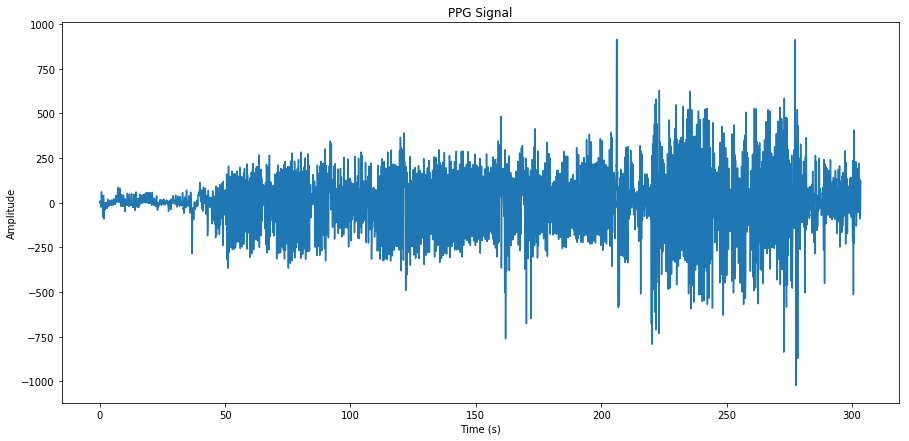

In [4]:
fs = 125
window = 2

ds, ref = LoadTroikaDataset()
ds1 = ds[0]
ds1 = LoadTroikaDataFile(ds1)
ds1
ppg, accx, accy, accz = ds1
ts = np.arange(0,len(ppg)/fs,1/fs)
plt.figure(figsize=(15,7))
plt.plot(ts,ppg)
plt.title("PPG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

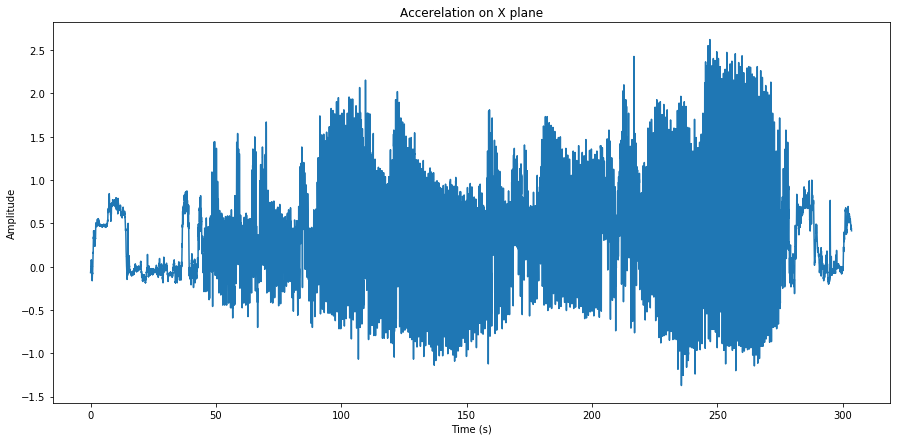

In [5]:
ppg, accx, accy, accz = ds1
ts = np.arange(0,len(accx)/fs,1/fs)
plt.figure(figsize=(15,7))
plt.plot(ts,accx)
plt.title("Accerelation on X plane")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

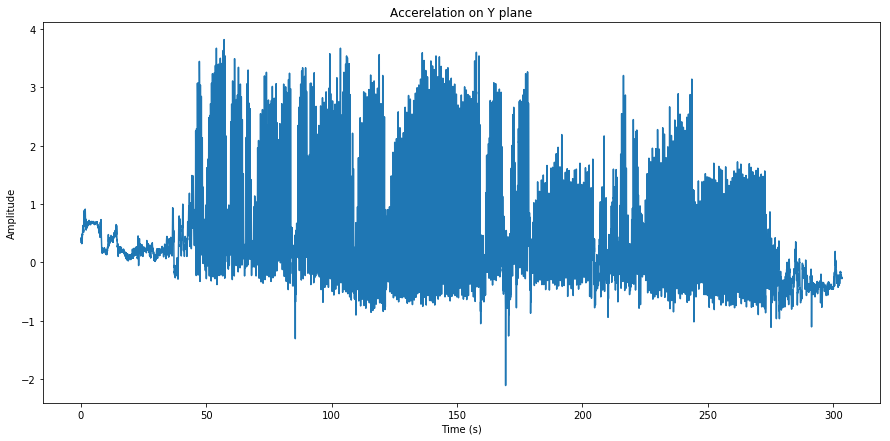

In [6]:
ppg, accx, accy, accz = ds1
ts = np.arange(0,len(accy)/fs,1/fs)
plt.figure(figsize=(15,7))
plt.plot(ts,accy)
plt.title("Accerelation on Y plane")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

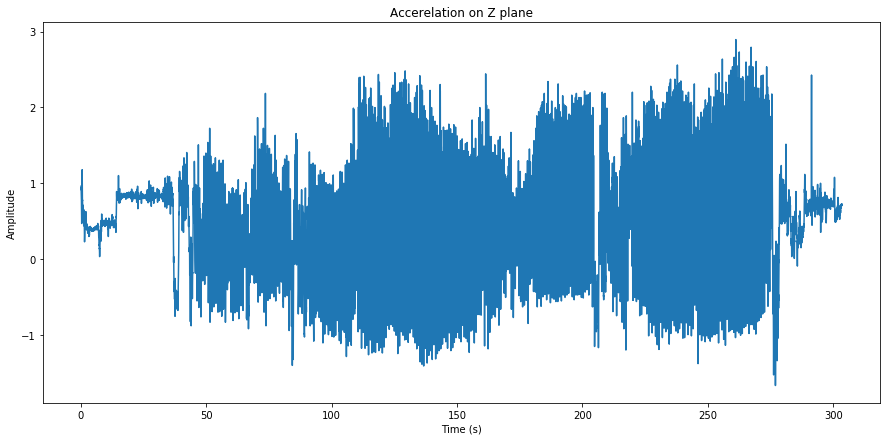

In [7]:
ppg, accx, accy, accz = ds1
ts = np.arange(0,len(accz)/fs,1/fs)
plt.figure(figsize=(15,7))
plt.plot(ts,accz)
plt.title("Accerelation on Z plane")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [8]:
errors, confidence= RunPulseRateAlgorithm(ds[0],ref[0])
confidence

array([ 0.35439383,  0.58005256,  0.56318607,  0.37266692,  0.58690027,
        0.61747349,  0.26978525,  0.33623003,  0.56854565,  0.53120958,
        0.13586463,  0.39659506,  0.44304966,  0.43482781,  0.11329174,
        0.07609913,  0.10002745,  0.30885978,  0.21213171,  0.34507665,
        0.43885097,  0.2803305 ,  0.21765426,  0.24530357,  0.31006569,
        0.28959901,  0.03764732,  0.21106872,  0.16800812,  0.01055561,
        0.26440555,  0.20012874,  0.31394434,  0.28439867,  0.43456235,
        0.019887  ,  0.3660794 ,  0.09427243,  0.1923879 ,  0.40131066,
        0.35534855,  0.29227465,  0.25051372,  0.39737203,  0.20677698,
        0.30535221,  0.30903586,  0.30975096,  0.32122411,  0.40505008,
        0.57951987,  0.39432262,  0.30909309,  0.20092799,  0.4960091 ,
        0.24006246,  0.01298354,  0.02578087,  0.5568392 ,  0.20732801,
        0.07166786,  0.2436924 ,  0.27809976,  0.02901352,  0.03343381,
        0.39928871,  0.38974526,  0.0195015 ,  0.0277559 ,  0.01

##### Code description

The code estimates pulse rate from PPG and acceleromter sensor signals. The ground truth pulse rate is taken from ECG signals measured contemporaneously.


##### Algorithm description

* This algorithm uses signal data generated by the PPG sensors worn on a user's wrist to estimate pulse rate. 

* The sensors emit light into a user's wrist and detects the amount of light reflecting back to the PPG's photodector. 

* The physiological aspect that a PPG measures is the amount of blood cells in one area. When the heart contracts, blood fills the extremities. When the heart relaxes, blood leaves the extremities and fill the heart.

* PPG readings are high when the heart contracts and PPG readings are lower when the heart relaxes. The heart beats are typically a steady pulse rhythm, so these readings form a waveform whose period can be used to determine the pulse rate.

* With the heart contractions, arm motions causes blood movement to the wrist. When running or walking, the arm movement can add another cadence to the PPG sensor measurements. The movements are periodic  to separate these 3-axis accelerometers is used.

* Sometimes, the strongest PPG frequency is the actual heart rate. However, the cadence of the arm swing is the same as the heartbeat. As a result, that PPG frequency is ruled out.

##### Data description

* Data used for training is taken from [TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise.](https://ieeexplore.ieee.org/document/6905737)
  - 12 subjects aged 18 to 35 were monitored as each subject ran on a treadmill with changing speeds for 5 minutes in this interval in their study

* In this study where the data was obtained there is also ground truth data provided which is gold standard since they collected the data.
* Sensors used to generate data
    - ECG sensors
    - PPG sensors
    - Accelerometer sensors


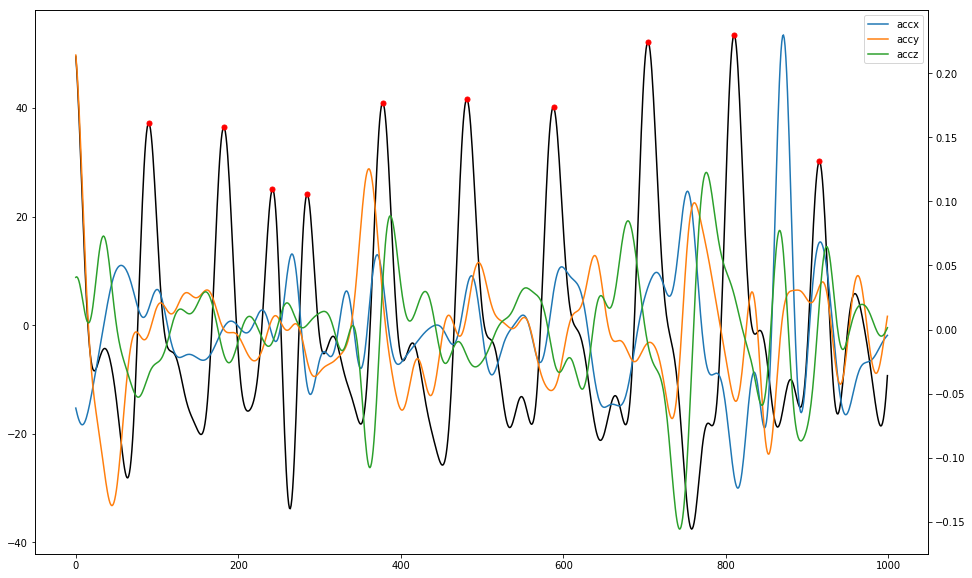

In [9]:
fs = 125
data_list = [ppg, accx, accy, accz]
label_list = ['ppg', 'accx', 'accy', 'accz']

filtered = {label : BandpassFilter(data) for (label, data) in zip(label_list, data_list)}
ppg_sig = filtered['ppg'][1000:2000]
pks = sp.signal.find_peaks(ppg_sig, height=15, distance=35)[0]

fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()

ax1.plot(ppg_sig, 'black')
ax1.plot(pks, ppg_sig[pks], 'r.', ms=10)

for label in label_list[1:]:
    ax2.plot(filtered[label][1000:2000], label=label)
    ax2.legend(loc='upper right')

plt.show()


##### Outputs

Characteristic frequencies for the PPG data is compared against the dominant characteristic frequencies for each accelerometer axis per time window.

The Confidence of each frequency's determination is calulated as intensity magnitudes near the charactistic frequncy divided by the sum of intensity magnitudes across all frequencies. This method to calculate confidence is similar to Signal to Noise ratio calculation, where a higher result indicates fewer noise frequencies that are
not characteristic of the pulse rate. One may select BPM estimates above a threshold confidence while discarding those below the threshold.

The Absolute Errors are calculated between the determined PPG frequency and the reference ECG pulse rate data.
The output from this algorithm only takes into account arm movement noise that is periodic.
It doesn't remove non-periodic movements.
This algorithm also doesn't account for other noise sources such as ambient light or shifts in sensor position.

##### Algorithm performance

This algorithm ouputs error is 11.9595 with training dataset, while the test dataset error is 7.55.



-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 